## Anaysis: Sep W3

### Problem statement: Given opinion as an input, generate outputs which can be classified into 5 tasks
- Given Opinion(input), 
    - Task 1: generate Opinion Summary(output)
    - Task 2: generate Primary Holding(output)
    - Task 3: generate Facts of the case(output)
    - Task 4: generate Question(output)
    - Task 5: generate Conclusion(output)

### Issues
- 1) Opinion is too long that scraping fails to include all opinions
    - If you can tell us how you scraped files, we will modify ways to scrape entire opinions
    - Suggstion: divide syllabus / opinion / dissent when scraping (if applicable)
    
    
- 2) Null values exists, and sometimes there are too many null counts for some tasks
    - For example, task1 has only 1460 complete set to train(17.7%), while there are 8235 examples in total
    - Suggestion: just use this avilable sets and maybe we can use null rows as a test set 
    - If so, We need some human resources(i.e. lawyers) to see if the result of a test set is okay

In [1]:
# if you fail to open xlsx, install openpyxl
# pip install openpyxl

In [14]:
# import basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

# additional libraries
import gc
import time
# %%time

oyez = pd.read_excel('NYU_Oyez_data.xlsx')
oyez.head(3)

,name,href,docket_number,term,description,justia_url,file_name_oyez,file_name_justia,facts_of_the_case,question,conclusion,Justia_summary,Justia_holding,Justia_txt,Justia_auth_txt
0,Oklahoma v. Castro-Huerta,https://api.oyez.org/cases/2021/21-429,21-429,2021,A case in which the Court held that a state ha...,https://supreme.justia.com/cases/federal/us/59...,2021_21-429,federal_us_597_21-429,"Victor Manuel Castro-Huerta, a non-Native, was...",Do states have the authority to prosecute non-...,The federal government and the state have conc...,Castro-Huerta was convicted of child neglect i...,The federal government and the state have conc...,"NOTE:Where it is feasible, a syllabus (headnot...",Syllabus &&& Opinion (Kavanaugh) &&& Dissent (...
1,Biden v. Texas,https://api.oyez.org/cases/2021/21-954,21-954,2021,A case in which the Court held that the Biden ...,https://supreme.justia.com/cases/federal/us/59...,2021_21-954,federal_us_597_21-954,"In 2018, the Trump administration announced th...",Must the Biden administration continue to enfo...,The Government’s rescission of Migrant Protect...,"In 2019, the Department of Homeland Security i...",The rescission of the Migrant Protection Proto...,"NOTE:Where it is feasible, a syllabus (headnot...",Syllabus &&& Opinion (Roberts) &&& Concurrence...
2,Shoop v. Twyford,https://api.oyez.org/cases/2021/21-511,21-511,2021,A case in which the Court held a transportatio...,https://supreme.justia.com/cases/federal/us/59...,2021_21-511,federal_us_596_21-511,"In 1993, an Ohio jury convicted Raymond Twyfor...",May a federal district court order the transpo...,A transportation order that allows a prisoner ...,Twyford was convicted of aggravated murder and...,A transportation order that allows a prisoner ...,"NOTE:Where it is feasible, a syllabus (headnot...",Syllabus &&& Opinion (Roberts) &&& Dissent (Go...


## columns
- name: case name
- href: api reference
- docket_number: case number
- term: year
- description: short description (this can be used in summary)
- justia_url: case url
- file_name_oyez: case number
- file_name_justia: case number
- <b> facts_of_the_case: task3 Output </b>
- <b> question: task4 Output </b>
- <b> conclusion: task5 Output </b>
- <b> Justia_summary: task1 Output </b>
- <b> Justia_holding: task2 Output </b>
- <b> Justia_txt: Input  </b>
- Justia_auth_txt: Input explanation

In [15]:
oyez.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8235 entries, 0 to 8234
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   name               8235 non-null   object
 1   href               8235 non-null   object
 2   docket_number      8235 non-null   object
 3   term               8235 non-null   object
 4   description        1533 non-null   object
 5   justia_url         7961 non-null   object
 6   file_name_oyez     8235 non-null   object
 7   file_name_justia   7961 non-null   object
 8   facts_of_the_case  3561 non-null   object
 9   question           3562 non-null   object
 10  conclusion         3551 non-null   object
 11  Justia_summary     1460 non-null   object
 12  Justia_holding     1278 non-null   object
 13  Justia_txt         7936 non-null   object
 14  Justia_auth_txt    7936 non-null   object
dtypes: object(15)
memory usage: 965.2+ KB


In [16]:
# total dataset: 8235 cases
oyez.shape

(8235, 15)

In [17]:
# no duplicates
oyez.drop_duplicates().shape

(8235, 15)

In [18]:
oyez.nunique()

name                 7929
href                 8235
docket_number        6591
term                   71
description          1531
justia_url           7961
file_name_oyez       8235
file_name_justia     7961
facts_of_the_case    3560
question             3552
conclusion           3541
Justia_summary        782
Justia_holding       1274
Justia_txt           7935
Justia_auth_txt       768
dtype: int64

In [19]:
# checking first case as an example
for col in oyez.columns:
    print(col, oyez.head(1)[col].values)
    print()

name ['Oklahoma v. Castro-Huerta']

href ['https://api.oyez.org/cases/2021/21-429']

docket_number ['21-429']

term ['2021']

description ['A case in which the Court held that a state has concurrent jurisdiction to prosecute non-Natives who commit crimes against Natives on Native American lands.']

justia_url ['https://supreme.justia.com/cases/federal/us/597/21-429/']

file_name_oyez ['2021_21-429']

file_name_justia ['federal_us_597_21-429']

facts_of_the_case ['Victor Manuel Castro-Huerta, a non-Native, was convicted in Oklahoma state court of child neglect, and he was sentenced to 35 years. The victim, his stepdaughter, is Native American, and the crime was committed within the Cherokee Reservation.Castro-Huerta challenged his conviction, arguing that under the Supreme Court’s 2020 decision in McGirt v. Oklahoma, which held that states cannot prosecute crimes committed on Native American lands without federal approval. Oklahoma argued that McGirt involved a Native defendant, whereas

In [20]:
# we can see that opinion is not fully scraped
# https://supreme.justia.com/cases/federal/us/597/21-429/
print(oyez.head(1)['Justia_txt'].values)

['NOTE:Where it is feasible, a syllabus (headnote) will be released, as is being done in connection with this case, at the time the opinion is issued. The syllabus constitutes no part of the opinion of the Court but has been prepared by the Reporter of Decisions for the convenience of the reader. See United States v. Detroit Timber & Lumber Co.,\n200 U.S. 321, 337. SUPREME COURT OF THE UNITED STATES Syllabus Oklahoma v. Castro-Huerta certiorari to the court of criminal appeals of oklahoma No. 21429.Argued April 27, 2022Decided June 29, 2022 In 2015, respondent Victor Manuel Castro-Huerta was charged by the State of Oklahoma for child neglect.  Castro-Huerta was convicted in state court and sentenced to 35 years of imprisonment.  While Castro-Huertas state-court appeal was pending, this Court decided McGirt v. Oklahoma, 591 U.S. ___.  There, the Court held that the Creek Nations reservation in eastern Oklahoma had never been properly disestablished and therefore remained Indian country.

In [21]:
# creating some conditions to check non-null counts
input1 = ~oyez['Justia_txt'].isnull()
task1 = ~oyez['Justia_summary'].isnull()
task2 = ~oyez['Justia_holding'].isnull()
task3 = ~oyez['facts_of_the_case'].isnull()
task4 = ~oyez['question'].isnull()
task5 = ~oyez['conclusion'].isnull()

print('total avilable data(rows): ', oyez.shape[0])
print('task1 available data(rows): {}, percentage: {}%'.format(len(oyez[input1&task1]), \
                                                               round(len(oyez[input1&task1])/oyez.shape[0]*100,2)))
print('task2 available data(rows): {}, percentage: {}%'.format(len(oyez[input1&task2]), \
                                                               round(len(oyez[input1&task2])/oyez.shape[0]*100,2)))
print('task3 available data(rows): {}, percentage: {}%'.format(len(oyez[input1&task3]), \
                                                               round(len(oyez[input1&task3])/oyez.shape[0]*100,2)))
print('task4 available data(rows): {}, percentage: {}%'.format(len(oyez[input1&task4]), \
                                                               round(len(oyez[input1&task4])/oyez.shape[0]*100,2)))
print('task5 available data(rows): {}, percentage: {}%'.format(len(oyez[input1&task5]), \
                                                               round(len(oyez[input1&task5])/oyez.shape[0]*100,2)))

total avilable data(rows):  8235
task1 available data(rows): 1460, percentage: 17.73%
task2 available data(rows): 1278, percentage: 15.52%
task3 available data(rows): 3359, percentage: 40.79%
task4 available data(rows): 3358, percentage: 40.78%
task5 available data(rows): 3358, percentage: 40.78%


In [22]:
## how long is opinion? longer than maximum length: 32,767
oyez['len_Justia_txt'] = oyez['Justia_txt'].apply(lambda x: len(str(x)))

In [23]:
oyez['len_Justia_txt'].value_counts().sort_index()

3         299
198         1
205         1
231         1
257         1
         ... 
32743       1
32745       1
32753       1
32763       2
32767    4805
Name: len_Justia_txt, Length: 2974, dtype: int64

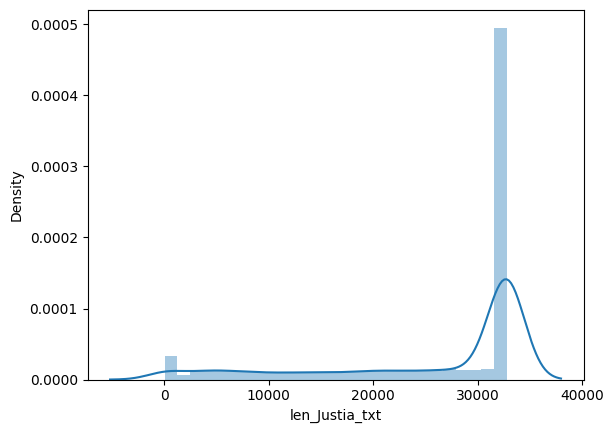

In [32]:
sns.distplot(oyez['len_Justia_txt'])
plt.show()

In [33]:
max(oyez['len_Justia_txt'])

32767

In [34]:
## summary: not to long 
oyez['len_Justia_summary'] = oyez['Justia_summary'].apply(lambda x: len(str(x)))

In [35]:
oyez['len_Justia_summary'].value_counts().sort_index()

3       6775
10       679
279        1
455        1
627        1
        ... 
3033       1
3169       1
3281       1
3301       1
3445       1
Name: len_Justia_summary, Length: 585, dtype: int64

In [36]:
max(oyez['len_Justia_summary'])

3445

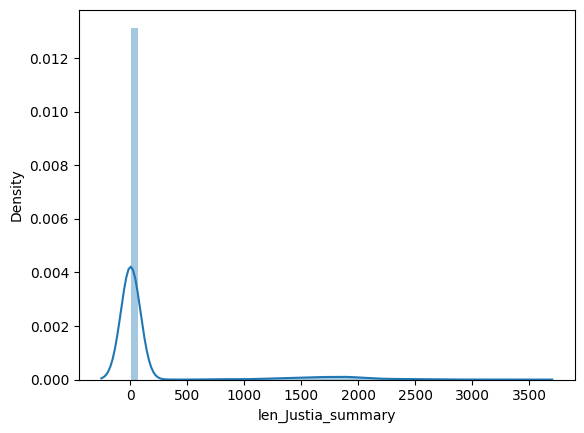

In [37]:
sns.distplot(oyez['len_Justia_summary'])
plt.show()

### Task1: Given Opinion(input) generate Opinion Summary(output)

#### - How? 
- Select any base model(t5, bart, pegasus, etc) 
- Fine-tune with our data
- Check the result (ROUGE score, and by eyeballing)
- If the result is good, then we can apply to the test dataset

In [38]:
# filter by non-null conditions for task1
task1_df = oyez[input1&task1]
task1_df.shape

(1460, 17)

In [39]:
task1_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 0 to 8221
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   name                1460 non-null   object
 1   href                1460 non-null   object
 2   docket_number       1460 non-null   object
 3   term                1460 non-null   object
 4   description         1023 non-null   object
 5   justia_url          1460 non-null   object
 6   file_name_oyez      1460 non-null   object
 7   file_name_justia    1460 non-null   object
 8   facts_of_the_case   1300 non-null   object
 9   question            1298 non-null   object
 10  conclusion          1300 non-null   object
 11  Justia_summary      1460 non-null   object
 12  Justia_holding      1278 non-null   object
 13  Justia_txt          1460 non-null   object
 14  Justia_auth_txt     1460 non-null   object
 15  len_Justia_txt      1460 non-null   int64 
 16  len_Justia_summary  1460

In [40]:
task1_df['len_Justia_txt'][task1_df['len_Justia_txt'] != 32767].value_counts()

23849    2
28652    1
9927     1
4569     1
19880    1
        ..
20716    1
10103    1
12740    1
24972    1
12125    1
Name: len_Justia_txt, Length: 338, dtype: int64

In [42]:
len(task1_df['len_Justia_txt'][task1_df['len_Justia_txt'] != 32767].value_counts())

338

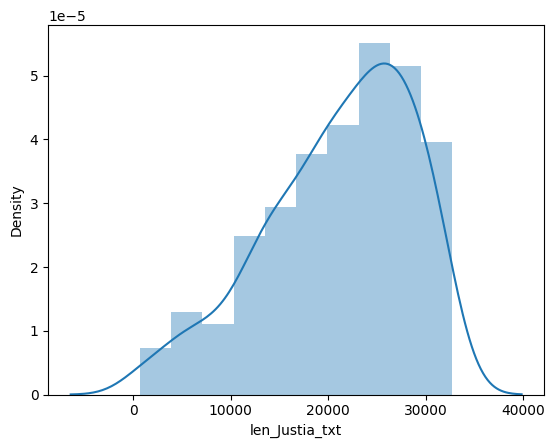

In [41]:
# excluding max counts
sns.distplot(task1_df['len_Justia_txt'][task1_df['len_Justia_txt'] != 32767])
plt.show()

In [43]:
task1_df['len_Justia_summary'].value_counts().sort_index()

10      679
279       1
455       1
627       1
654       1
       ... 
3033      1
3169      1
3281      1
3301      1
3445      1
Name: len_Justia_summary, Length: 584, dtype: int64

In [44]:
# Question: if summary is just 'annotation, do we need to take it or not?'
# for now, we exclude those examples (however, those are 1/3 of total dataset)
task1_df[task1_df['len_Justia_summary'] == 10]

,name,href,docket_number,term,description,justia_url,file_name_oyez,file_name_justia,facts_of_the_case,question,conclusion,Justia_summary,Justia_holding,Justia_txt,Justia_auth_txt,len_Justia_txt,len_Justia_summary
481,Thornburgh v. Abbott,https://api.oyez.org/cases/1988/87-1344,87-1344,1988,A case in which the Court held that the First ...,https://supreme.justia.com/cases/federal/us/49...,1988_87-1344,federal_us_490_401,Jack Abbott and other prisoners were denied ac...,Does the First Amendment prohibit the Federal ...,No. Justice Harry A. Blackmun delivered the op...,Annotation,If it is reasonably related to a legitimate in...,Thornburgh v. Abbott No. 87-1344 Argued Novemb...,Syllabus &&& Case,32767,10
485,Bolling v. Sharpe,https://api.oyez.org/cases/1940-1955/347us497,8,1940-1955,A case in which the Court held the Fifth Amend...,https://supreme.justia.com/cases/federal/us/34...,1940-1955_347us497,federal_us_347_497,The D.C. Board of Education denied a petition ...,Did the segregation of the public schools of W...,"The Fifth Amendment's guarantee of ""liberty"" p...",Annotation,Mirroring the decision in Brown v. Board of Ed...,"Bolling v. Sharpe No. 8 Argued December 10-11,...",Syllabus &&& Case,7034,10
486,Brown v. Board of Education of Topeka (1),https://api.oyez.org/cases/1940-1955/347us483,1,1940-1955,"A case in which the Court decided that the ""se...",https://supreme.justia.com/cases/federal/us/34...,1940-1955_347us483,federal_us_347_483,This case was the consolidation of cases arisi...,Does the segregation of public education based...,Separate but equal educational facilities for ...,Annotation,The Equal Protection Clause of the Fourteenth ...,Brown v. Board of Education of Topeka Argued D...,Syllabus &&& Case,26151,10
499,Youngstown Sheet & Tube Company v. Sawyer,https://api.oyez.org/cases/1940-1955/343us579,744,1940-1955,A case in which the Court held that the Presid...,https://supreme.justia.com/cases/federal/us/34...,1940-1955_343us579,federal_us_343_579,"In April of 1952, during the Korean War, Presi...",Did the President have the constitutional auth...,"In a 6-to-3 decision, the Court held that the ...",Annotation,The President cannot take possession of privat...,Youngstown Sheet & Tube Co. v. Sawyer Argued M...,Syllabus &&& Case,32767,10
501,Beauharnais v. Illinois,https://api.oyez.org/cases/1940-1955/343us250,118,1940-1955,A case in which the Court decided that a state...,https://supreme.justia.com/cases/federal/us/34...,1940-1955_343us250,federal_us_343_250,Joseph Beauharnais circulated leaflets petitio...,Did Beuharnais' conviction under the Illinois ...,In a 5-4 opinion authored by Justice Felix Fra...,Annotation,Acts of criminal libel that target specific gr...,Beauharnais v. Illinois No. 118 Argued Novembe...,Syllabus &&& Case,32767,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8190,Miller v. California,https://api.oyez.org/cases/1971/70-73,70-73,1971,"A case in which the Court found that ""obscene ...",https://supreme.justia.com/cases/federal/us/41...,1971_70-73,federal_us_413_15,"Miller, after conducting a mass mailing campai...",Is the sale and distribution of obscene materi...,"In a 5-to-4 decision, the Court held that obsc...",Annotation,Speech that is obscene and thus lacking First ...,Miller v. California No. 70-73 Argued January ...,Syllabus &&& Case,32767,10
8191,California Motor Transport Company v. Trucking...,https://api.oyez.org/cases/1971/70-92,70-92,1971,NaN,https://supreme.justia.com/cases/federal/us/40...,1971_70-92,federal_us_404_508,NaN,NaN,NaN,Annotation,Citizens have the right to make petitions to a...,California Motor Transport Co. v. Trucking Unl...,Syllabus &&& Case,22589,10
8200,Reed v. Reed,https://api.oyez.org/cases/1971/70-4,70-4,1971,A case in which the Court established the unco...,https://supreme.justia.com/cases/federal/us/40...,1971_70-4,federal_us_404_71,"The Idaho Probate Code specified that ""males m...",Did the Idaho Probate Code violate the 

In [60]:
task1_df[task1_df['len_Justia_summary'] == 10]['justia_url'].values

array(['https://supreme.justia.com/cases/federal/us/490/401/',
       'https://supreme.justia.com/cases/federal/us/347/497/',
       'https://supreme.justia.com/cases/federal/us/347/483/',
       'https://supreme.justia.com/cases/federal/us/343/579/',
       'https://supreme.justia.com/cases/federal/us/343/250/',
       'https://supreme.justia.com/cases/federal/us/341/494/',
       'https://supreme.justia.com/cases/federal/us/340/349/',
       'https://supreme.justia.com/cases/federal/us/340/315/',
       'https://supreme.justia.com/cases/federal/us/336/525/',
       'https://supreme.justia.com/cases/federal/us/336/106/',
       'https://supreme.justia.com/cases/federal/us/334/1/',
       'https://supreme.justia.com/cases/federal/us/333/203/',
       'https://supreme.justia.com/cases/federal/us/330/75/',
       'https://supreme.justia.com/cases/federal/us/330/1/',
       'https://supreme.justia.com/cases/federal/us/326/501/',
       'https://supreme.justia.com/cases/federal/us/325/761/

In [45]:
task1_df = task1_df[task1_df['len_Justia_summary'] != 10]
task1_df.shape

(781, 17)

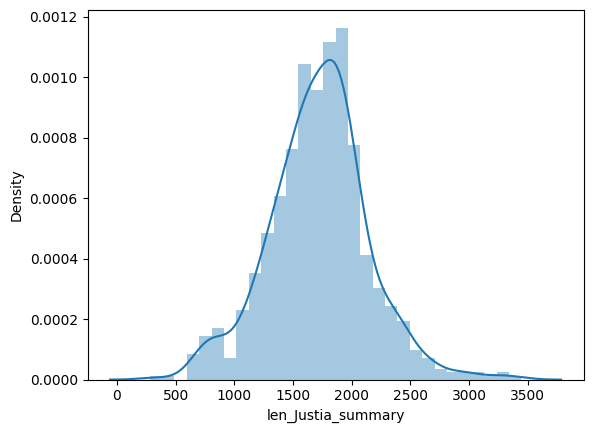

In [46]:
# excluding max counts
sns.distplot(task1_df['len_Justia_summary'])
plt.show()

In [47]:
task1_df.nunique()

name                  772
href                  781
docket_number         781
term                   12
description           779
justia_url            781
file_name_oyez        781
file_name_justia      781
facts_of_the_case     781
question              778
conclusion            781
Justia_summary        781
Justia_holding        600
Justia_txt            781
Justia_auth_txt       492
len_Justia_txt        233
len_Justia_summary    583
dtype: int64

In [51]:
task1_df_v2 = task1_df[['file_name_oyez', 'Justia_txt', 'Justia_summary']]
task1_df_v2.columns = ['id', 'document', 'summary']
task1_df_v2

,id,document,summary
0,2021_21-429,"NOTE:Where it is feasible, a syllabus (headnot...",Castro-Huerta was convicted of child neglect i...
1,2021_21-954,"NOTE:Where it is feasible, a syllabus (headnot...","In 2019, the Department of Homeland Security i..."
2,2021_21-511,"NOTE:Where it is feasible, a syllabus (headnot...",Twyford was convicted of aggravated murder and...
3,2021_21-439,"NOTE:Where it is feasible, a syllabus (headnot...",A prisoner who challenges a state’s proposed m...
4,2021_21-499,"NOTE:Where it is feasible, a syllabus (headnot...",Los Angeles County Deputy Vega questioned Teko...
...,...,...,...
3354,2010_09-993,"PLIVA, INC., etal. v. MENSING certiorari to th...",These consolidated lawsuits involved state tor...
3356,2010_10-188,SCHINDLER ELEVATOR CORP. v. UNITED STATES ex r...,Respondent filed an action under the False Cla...
3357,2010_10-5400,TAPIA v. UNITED STATES certiorari to the unite...,"Petitioner was convicted of, inter alia, smugg..."
3360,2010_09-1227,BOND v. UNITED STATES certiorari to the united...,Petitioner was indicted for violating 18 U.S.C...
